# IMDB-LSTM-SIGMOD

아래의 내용을 실행하고 나온 결과 값입니다.
[0.9644113788795471, 0.834719999961853]

1. 실제 데이터에 대한 상세 기술 
 - IMDB(인터넷 영화 데이터베이스)의 데이터에서 제공한 데이터들 중 양극단(긍정적,부정적) 리뷰의 단어들의 데이터셋입니다.
 - 훈련 데이터로는 2만 5000개의 데이터와 같은 수의 테스트 데이터로 구성되어 있으며 훈련 데이터를 2만개와 검증 데이터 5천개로 나누어 진행할    것입니다.
 - 데이터의 내용은 빈도수가 가장 높은 5000개 단어들로 구성하였습니다.

In [1]:
#imdb에서 제공하는 데이터를 가져온는 과정
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
import numpy as np

max_features = 5000
text_max_words = 200

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_features)



Using TensorFlow backend.


In [2]:
#가져온 데이터의 갯수 파악
print("트레이닝 데이터 :", len(train_data))
print("테스트 데이터 :", len(test_data))

트레이닝 데이터 : 25000
테스트 데이터 : 25000


In [3]:
# 데이터 내용을 확인하기 위하여 index를 매핑시킬 수 있는 딕셔너리 생성
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 첫번째 데이터에 있는 문자 확인과 이 내용이 긍정적인지 부정적인지 같은 인덱스에 존재하는 레이블을 이용하여 확인
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

if train_labels[0] == 1 :
    print("긍정적인 내용")
else:
    print("부정적인 내용")
decoded_review

긍정적인 내용


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly ? was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little ? that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big ? for the whole film but these children are amazing and should be ? for what they have done don't you think the whole story wa

2. 예측하고자 하는 방법/방향 기술 
 - 특정한 단어의 집합으로 이루어진 양극단 데이터를 학습시킨 모델에 데이터를 입력할 때에 그 데이터가 긍정인지 부정인지 예측하기위하여 진행    하였습니다.

In [4]:
#5. 생성된 모델의 model.summary() 출력
x_val = train_data[:20000]
partial_x_train = train_data[20000:]

y_val = train_labels[:20000]
partial_y_train = train_labels[20000:]

In [5]:
# 데이터를 벡터로 변환
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
partial_x_train = sequence.pad_sequences(partial_x_train, maxlen=text_max_words)
x_test = sequence.pad_sequences(test_data, maxlen=text_max_words)

# 레이블의 자료형을 변경하여 불필요한 데이터 손실이 없게 변환
y_train = np.asarray(y_val).astype('float32')
partial_y_train = np.asarray(partial_y_train).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

3. 학습을 위해 데이터가 어떻게 가공/처리되었는지 기술 
 - 각 데이터마다 길이가 상이하므로 같은 길이로 맞추어 모델의 입력으로 사용하기 위해서 데이터 길이의 크기를 200으로 변경하였습니다.
   (모든 단어를 같은 길이로 맞춰주는 이유는 모델에서 데이터를 사용하기 위해서는 고정된 길이로 만들어줘야 하기 때문입니다.)
 - 레이블의 데이터는 스칼라 형식이므로 데이터 연산시 불필요한 데이터 손실이 없도록 정수형에서 실수형으로 변경하였습니다.

4. 사용된 모델의 특징에 대한 기술 
 - 이번 모델에서 사용한 레이어 중 중점인 레이어는 LSTM입니다.
 - LSTM 레이어는 가장 큰 특징은 기존에 사용해봤었던 데이터들과는 다르게 기존의 데이터를 기억하고 그 데이터를 이용하여 현재의 데이터에 사용   을 하는 것이 가장 큰 특징입니다.
 - RNN의 단점인 장기종속성 아래와 같은 방법으로 해결하였습니다.
   (원래 한 레이어 였던것을 여러개의 레이어를 이용하여 각 레이어에서 나온 정보를 주고받아서 RNN의 단점을 해결하였습니다.)

In [6]:
model = Sequential()
#Embedding input_lehth의 값이 200으로 되어 있는데 그 이유는 아까전에 pad_sequences에서 200으로 잘라줬기 때문이다.
#5000길이의 데이터를 128개로 나눠서 다음 레이어로 던짐
#Embedding 1. 단어사전의 총 크기, 2. 인코딩 한 후 나오는 벡터의 크기 3. 다음이 LSTM층이기 때문에 자동으로 input_lenght의 설정을 해주므로 작성해야할 필요성이 없음
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
#각 층마다 사용되는 파라미터의 값과 구성이 어떻게 되었는지 간단하게 알 수 있음
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________


In [9]:
#epoch은 최소 25회 이상 진행 
hist = model.fit(x_val, y_val, epochs=25, batch_size=64, validation_data=(partial_x_train, partial_y_train))

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 135s 7ms/step - loss: 0.4538 - acc: 0.7846 - val_loss: 0.3569 - val_acc: 0.8458
Epoch 2/25
20000/20000 [==============================] - 136s 7ms/step - loss: 0.2987 - acc: 0.8784 - val_loss: 0.3451 - val_acc: 0.8560
Epoch 3/25
20000/20000 [==============================] - 135s 7ms/step - loss: 0.2309 - acc: 0.9092 - val_loss: 0.3472 - val_acc: 0.8596
Epoch 4/25
20000/20000 [==============================] - 136s 7ms/step - loss: 0.2062 - acc: 0.9196 - val_loss: 0.3792 - val_acc: 0.8566
Epoch 5/25
20000/20000 [==============================] - 136s 7ms/step - loss: 0.1493 - acc: 0.9447 - val_loss: 0.4152 - val_acc: 0.8530
Epoch 6/25
20000/20000 [==============================] - 137s 7ms/step - loss: 0.1322 - acc: 0.9519 - val_loss: 0.4492 - val_acc: 0.8460
Epoch 7/25
20000/20000 [==============================] - 137s 7ms/step - loss: 0.1397 - acc: 0.9476 - val_loss: 0.4616 - v

In [10]:
#그림으로 표현하기 위해서 history 데이터를 분리
history_dict = hist.history

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

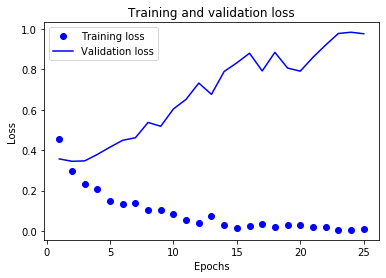

In [14]:
import matplotlib.pyplot as plt

#손실을 그래프로 표시
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# 그래프를 초기화
plt.clf()  

<Figure size 432x288 with 0 Axes>

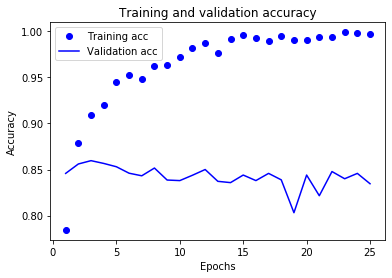

In [16]:
#정확도를 그래프로 표시
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 27s 1ms/step
## evaluation loss and_metrics ##
[0.9644113788795471, 0.834719999961853]


# LSTM 종료